In [4]:
from src.utils.mouselab_jas import MouselabJas
from src.utils.distributions import Normal
from src.utils.env_creation import create_tree, create_init
from src.utils.env_export import create_json
from src.utils.data_classes import MouselabConfig
from simulation import run_simulation
from src.policy.jas_voc_policy import JAS_voc_policy
from src.policy.jas_policy import RandomPolicy, ExhaustivePolicy, RandomNPolicy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from src.utils.utils import sigma_to_tau
import numpy as np


sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.5)
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Fixed from paper
num_projects = 5
num_criteria = 6
weights = [0.0206795, 0.0672084, 0.2227102, 0.1067428, 0.4665054, 0.1161537]
expert_stds = [1.5616618964384956, 1.449172525995787, 1.5205992970609392, 1.5469422429523034, 1.511270787760881, 1.455189251463794]
expert_taus = list(sigma_to_tau(np.array(expert_stds)))

mu = [3.6, 3.1666666666666665, 3.6, 3.1333333333333333, 3.6666666666666665, 2.3]
sigma = [1.3544307876819288, 1.2617266038997932, 1.3796551293211172, 1.2521246311585852, 1.5161960871578068, 0.9523111632886272]

init = create_init([0]+(mu*num_projects), [0]+(sigma*num_projects))
expert_costs = [0.002]*6

config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=True)
env = MouselabJas(config=config)

In [8]:
create_json("./data/khalili_env.json", config, list(range(1, 31)))

In [10]:
pal = sns.color_palette("pastel")
print(pal.as_hex())

['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#cfcfcf', '#fffea3', '#b9f2f0']


In [ ]:
num_projects = 13
num_criteria = 5
init = create_init([5]*10, [0]+([40,20,40]*3))

In [3]:
num_projects = 3
num_criteria = 3
init = create_init([0]*10, [0]+([40,20,40]*3))
expert_costs = [0.5, 1, 0.6]
expert_taus = [0.3, 0.5, 0.2]
criteria_scale = [0.2, 3, 1.5]

ground_truth = [0, 12, 12, 12, 15, 5, 10, 12, 12, 12]
config = MouselabConfig(ground_truth=ground_truth)
env = MouselabJas(num_projects, num_criteria, init, expert_costs, expert_taus, criteria_scale=criteria_scale, config=config)

In [7]:
num_projects = 4
num_criteria = 8
init = create_init([0]*(1+4*8), [0]+([40,20,40,10,35,10,5,60]*num_projects))
expert_costs = [0.5, 1, 0.6, 5]
expert_taus = [0.03, 0.05, 0.02, 0.4]
criteria_scale = [0.2, 1, 1.5, 0.7, 0.5, 0.1, 0.1, 0.67]

config = MouselabConfig()
env = MouselabJas(num_projects, num_criteria, init, expert_costs, expert_taus, criteria_scale=criteria_scale, config=config)

In [8]:
create_json("./test_big.json", config, num_projects, num_criteria, init, expert_costs, expert_taus, criteria_scale, seeds=[i for i in range(10)])

In [9]:
voc_policy = JAS_voc_policy()
random_policy = RandomPolicy()
exhaustive_policy = ExhaustivePolicy()
random_6_policy = RandomNPolicy(N=6)

In [10]:
res_random = run_simulation(env, random_policy)
res_exhaustive = run_simulation(env, exhaustive_policy)
res_random_6 = run_simulation(env, random_6_policy)

In [11]:
res_voc = run_simulation(env, voc_policy, n=100)

In [12]:
res_voc["algorithm"] = "MGPO"
res_exhaustive["algorithm"] = "Exhaustive"
res_random["algorithm"] = "Random"
res_random_6["algorithm"] = "Random 6"
res = pd.concat([res_voc, res_exhaustive, res_random, res_random_6])

Text(0, 0.5, 'Actions')

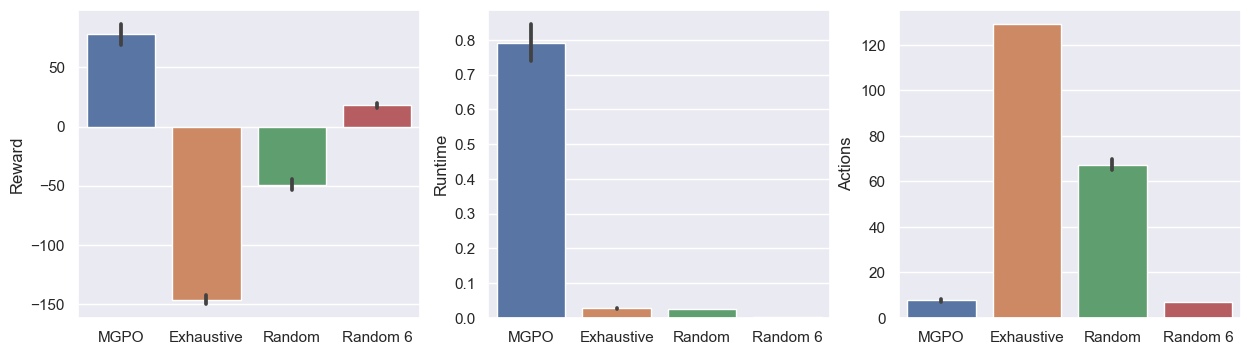

In [13]:
fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=False, sharey=False)
axes = axes.flatten()

g = sns.barplot(data=res, x="algorithm", y="reward", ax=axes[0])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Reward")

g = sns.barplot(data=res, x="algorithm", y="runtime", ax=axes[1])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Runtime")

g = sns.barplot(data=res, x="algorithm", y="actions", ax=axes[2])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Actions")